In [2]:
%load_ext autoreload
%autoreload 2
import os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
import mlflow 

from datetime import datetime
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Rescaling
from tensorflow.python.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input

from common_params import data_dir, img_dir
from common_plots import plot_img, plot_train_val_accuracy_and_loss
from data_load import get_train_val_set, apply_data_augmentation, prepare_subfolder_extract
from common_params import data_dir, img_dir, npy_dir, model_dir, MAX_NUMBER_CLASS, input_shape, image_size, IMG_SIZE
from common_img_functions import read_img
from common_mlflow import save_experiment_mlflow

In [76]:
print(tf.__version__)

2.11.0


In [78]:
model_run_config = {
    "experiment_name" : "xception-transfer-learning-dog-breed-classifier",
    "batch_size" : 32,
    "NB_IMG_PER_CLASS" : 150 ,
    "NB_CLASS" : 30 ,
    "num_epochs" : 30 ,
    "NB_NEURONS_DENSE_LAYER": 512,
    "droupout" : 0.8,
    # scale = 1
    "scale" : 1./255. ,
    "input_shape" : input_shape
}

batch_size              =  model_run_config['batch_size']
NB_IMG_PER_CLASS        =  model_run_config["NB_IMG_PER_CLASS"]
NB_CLASS                =  model_run_config["NB_CLASS"]
num_epochs              =  model_run_config["num_epochs"]
NB_NEURONS_DENSE_LAYER  =  model_run_config["NB_NEURONS_DENSE_LAYER"]
droupout                =  model_run_config["droupout"]
# scale = 1
scale                   =  model_run_config["scale"]
experiment_name         =  model_run_config["experiment_name"]
input_shape             =  model_run_config["input_shape"]

In [79]:
list_of_folder = np.load(os.path.join(npy_dir,"top_breed_folder_list_30.npy"),  allow_pickle=True)
train_dir, test_dir = prepare_subfolder_extract(NB_IMG_PER_CLASS, NB_CLASS, list_of_folder) 

# Transfer learning using Xception 

In [11]:
train_ds, validation_ds, class_names = get_train_val_set(train_dir, image_size, batch_size)

# train_ds, validation_ds = apply_data_augmentation(train_ds, validation_ds)



NameError: name 'train_dir' is not defined

In [81]:
class_names

['n02085936-Maltese_dog',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02088094-Afghan_hound',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02090721-Irish_wolfhound',
 'n02091134-whippet',
 'n02091244-Ibizan_hound',
 'n02091467-Norwegian_elkhound',
 'n02091831-Saluki',
 'n02092002-Scottish_deerhound',
 'n02095570-Lakeland_terrier',
 'n02095889-Sealyham_terrier',
 'n02096051-Airedale',
 'n02096177-cairn',
 'n02096294-Australian_terrier',
 'n02097474-Tibetan_terrier',
 'n02107683-Bernese_mountain_dog',
 'n02108000-EntleBucher',
 'n02110185-Siberian_husky',
 'n02110806-basenji',
 'n02110958-pug',
 'n02111129-Leonberg',
 'n02111277-Newfoundland',
 'n02111500-Great_Pyrenees',
 'n02111889-Samoyed',
 'n02112018-Pomeranian',
 'n02112137-chow']

In [82]:
def get_xception_model(scale=1):
    model = Sequential()
    if scale != 1 : 
        model.add(Rescaling(scale))
    model.add(Xception(include_top=False, pooling='avg', weights="imagenet"))
    model.add(Dense(NB_NEURONS_DENSE_LAYER, activation='relu'))
    model.add(Dropout(droupout))
    model.add(Dense(NB_CLASS, activation='softmax'))
    model.layers[0].trainable = False
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [83]:
xmodel = get_xception_model(scale=scale)

In [84]:
run_name = datetime.now().strftime("%Y%m%d_%H%M%S")
logdir = os.path.join(data_dir,"logs", experiment_name, run_name)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir,  write_graph=True, histogram_freq=1)

history = xmodel.fit(x=train_ds, 
        epochs=num_epochs, 
        validation_data=validation_ds,
        callbacks=[tensorboard_callback])

Epoch 1/30
152/152 [==============================] - 1174s 8s/step - loss: 1.8550 - accuracy: 0.4897 - val_loss: 1.7937 - val_accuracy: 0.5211
Epoch 2/30
152/152 [==============================] - 1111s 7s/step - loss: 1.0309 - accuracy: 0.7185 - val_loss: 2.1319 - val_accuracy: 0.5797
Epoch 3/30
152/152 [==============================] - 1111s 7s/step - loss: 0.7441 - accuracy: 0.8000 - val_loss: 1.3891 - val_accuracy: 0.6424
Epoch 4/30
152/152 [==============================] - 1118s 7s/step - loss: 0.5940 - accuracy: 0.8465 - val_loss: 1.6135 - val_accuracy: 0.6416
Epoch 5/30
152/152 [==============================] - 1125s 7s/step - loss: 0.5629 - accuracy: 0.8496 - val_loss: 1.1792 - val_accuracy: 0.6862
Epoch 6/30
152/152 [==============================] - 1112s 7s/step - loss: 0.4047 - accuracy: 0.8954 - val_loss: 0.9435 - val_accuracy: 0.7572
Epoch 7/30
152/152 [==============================] - 1109s 7s/step - loss: 0.3630 - accuracy: 0.9032 - val_loss: 1.6378 - val_accuracy:

MLflow’s mlflow.sklearn library allows loading models back as a scikit-learn Pipeline object.

In [85]:
save_experiment_mlflow(xmodel, model_run_config, run_name, history)

MLFlow Run ID:  20acd9cd81654a85bc287a9be718debf


INFO:tensorflow:Assets written to: C:\Users\clara\AppData\Local\Temp\tmp4ws6g5oq\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\clara\AppData\Local\Temp\tmp4ws6g5oq\model\data\model\assets


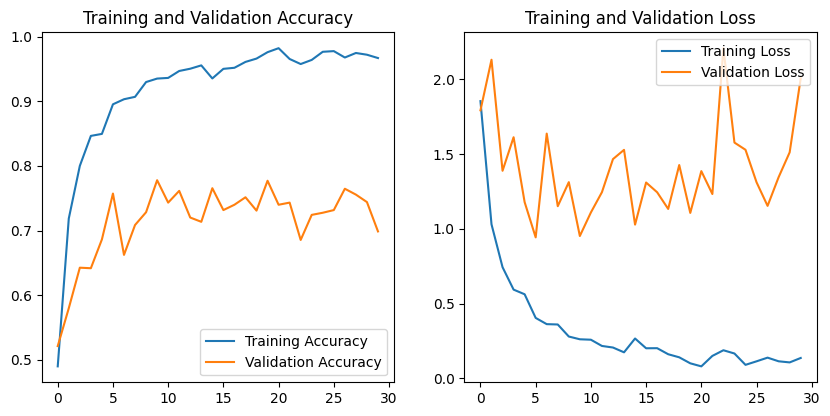

In [86]:
plot_train_val_accuracy_and_loss(history)

# Show single predictions  

load model 

In [5]:
test_img = read_img(os.path.join(data_dir , "extracted\\test\\n02085936-Maltese_dog\\n02085936_233_0.jpg"))
test_imge = np.expand_dims(test_img, axis=0)

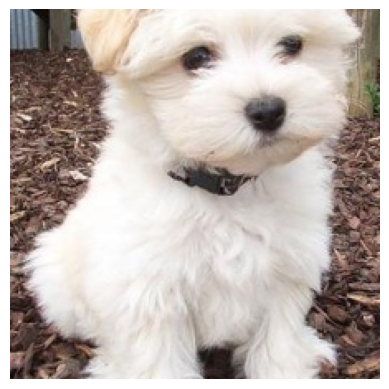

In [9]:
plot_img(test_img,correct_color=True)

In [10]:
class_names_from_folder = [ name.split('-')[1] for name in class_names ]
predictions = xmodel.predict(test_imge)[0]
print(f"This image as a probability {round(100*predictions[0],2)}% {class_names_from_folder[0]} of and a probability { round(100*predictions[1],2)}% of {class_names_from_folder[1]}")

NameError: name 'class_names' is not defined